# what are the features influencing students successfully finish ND

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
conn_hardy = psycopg2.connect("dbname='analytics' user='u_yidong' host='udacity-segment.c2zpsqalam7o.us-west-2.redshift.amazonaws.com' port='5439' password='Lyd580809?!'")

In [3]:
sql_apps = "SELECT distinct a.id as application_id,a.cohort_id,a.applicant_id,a.nd_key,a.application_type\
      ,coalesce(a.applicant_country,'Unknown') as applicant_country\
      ,coalesce(a.applicant_geo,'Unknown') as applicant_geo\
      ,case when b.user_id is not null then 'term completed'\
            when a.first_charge_created_at is not null and a.accepted_at is not null then 'paid'\
            when a.accepted_at is not null then 'accepted'\
            when a.rejected_at is not null then 'rejected'\
            when a.submitted_at is not null then 'submitted'\
       else 'applied' end as application_status\
      ,current_date - a.applicant_created_at::date as user_age\
      ,a.cohort_notify_at::date - a.cohort_open_at::date as cohort_open_to_notify\
      ,a.cohort_close_at::date - a.cohort_open_at::date as cohort_open_to_close\
      ,date_part('month',a.cohort_open_at) as cohort_open_month\
      ,date_part('month',a.application_created_at) as application_month\
      ,a.application_created_at::date - a.cohort_open_at::date as apply_before_start\
      ,a.submitted_at::date - a.application_created_at::date as apply_to_submit\
      ,coalesce(a.accepted_at,a.rejected_at)::date - a.submitted_at::date as submit_to_decision\
      ,a.first_charge_created_at::date - a.accepted_at::date as accepted_to_pay\
      ,coalesce(a.price,0)::int as price\
       FROM admissions.applications as a\
       LEFT JOIN enrollments.term_completions as b ON a.applicant_id = b.user_id and a.nd_key = b.nd_key\
       WHERE accepted_at is not null and first_charge_created_at is not null\
         AND email not like '%@udacity%';"

In [4]:
df_apps = pd.read_sql(sql_apps,conn_laurel)
df_apps.head()

,application_id,cohort_id,applicant_id,nd_key,application_type,applicant_country,applicant_geo,application_status,user_age,cohort_open_to_notify,cohort_open_to_close,cohort_open_month,application_month,apply_before_start,apply_to_submit,submit_to_decision,accepted_to_pay,price
0,d6ab011d-6073-4c35-a4c7-308ef8deec60,129,4594339126,nd889,term,IN,APAC,paid,42,70,50,8.0,9.0,48,0.0,22.0,10,800
1,1164203b-b70f-40ad-b9ad-3ae2b3440eec,18,5508058818,nd013,term,ES,EMEA,paid,228,88,70,2.0,4.0,64,1.0,21.0,1,700
2,bb5419e5-89be-452a-86b1-8242a69447f8,111,u21068647,nd889,term,US,US,paid,106,63,42,6.0,7.0,26,0.0,37.0,0,800
3,08a623ad-b8b8-430a-a061-8e12e3649527,88,10453193092,nd013,term,DE,EMEA,paid,94,70,56,6.0,7.0,38,0.0,33.0,0,800
4,1f804be5-2d1c-40c8-ada4-b10ddbfa5ff1,89,10361159465,nd013,term,US,US,paid,44,43,35,8.0,9.0,32,0.0,12.0,4,800


In [5]:
sql_course = "select application_id,cohort_id,user_id AS applicant_id,nanodegree_key AS nd_key\
       ,count(distinct course_key) as num_courses\
       ,count(distinct case when course_finished = 2 then course_key else null end) as num_course_finished\
       ,count(distinct case when course_finished = 1 then course_key else null end) as num_course_enrolled\
       ,current_date - first_course_started_at::date AS user_study_age\
 from (select distinct b.application_id,b.cohort_id,a.user_id,b.nanodegree_key,course_key,join_time,leave_time\
             ,first_value(join_time) over (partition by a.user_id order by join_time rows between unbounded preceding and unbounded following) as first_course_started_at\
             ,case when a.leave_time::Date <= b.received_at::Date then 2\
                   when a.leave_time is not null then 1 \
              else 0 end as course_finished\
       from analytics_tables.course_enrollments as a\
       inner join backend_admissions.application_received as b on a.user_id = b.user_id\
       where a.join_time <= b.received_at\
      ) group by application_id,cohort_id,user_id,nanodegree_key,current_date - first_course_started_at::date"

In [6]:
df_course = pd.read_sql(sql_course,conn_hardy)
df_course.head()

,application_id,cohort_id,applicant_id,nd_key,num_courses,num_course_finished,num_course_enrolled,user_study_age
0,95bdf9f5-cfb3-45f6-9207-bf6e30a88fbb,eu-google-sep-2017,10004281357,google-dev-scholarship,2,0,0,353
1,562feb46-4fbe-4a16-afe5-84b2db8660a6,eu-google-sep-2017,10010451920,google-dev-scholarship,1,0,0,331
2,ee07e506-1ab8-4843-beb7-7d825ed5973f,us-google-nov-2017,10012162209,grow-with-google-scholarships,1,0,0,351
3,c6c74fdd-79a4-4134-a4aa-b73d601412b7,eu-google-sep-2017,10021129138,google-dev-scholarship,2,0,0,348
4,7e231e1b-7689-4166-a23d-a03b28661a0c,220,10022232224,nd013,8,0,0,349


In [7]:
df = pd.merge(df_apps,df_course,on=['application_id','cohort_id','applicant_id','nd_key'],how='inner')
df.head()

,application_id,cohort_id,applicant_id,nd_key,application_type,applicant_country,applicant_geo,application_status,user_age,cohort_open_to_notify,...,application_month,apply_before_start,apply_to_submit,submit_to_decision,accepted_to_pay,price,num_courses,num_course_finished,num_course_enrolled,user_study_age
0,d6ab011d-6073-4c35-a4c7-308ef8deec60,129,4594339126,nd889,term,IN,APAC,paid,42,70,...,9.0,48,0.0,22.0,10,800,11,1,0,852
1,1164203b-b70f-40ad-b9ad-3ae2b3440eec,18,5508058818,nd013,term,ES,EMEA,paid,228,88,...,4.0,64,1.0,21.0,1,700,5,0,0,623
2,bb5419e5-89be-452a-86b1-8242a69447f8,111,u21068647,nd889,term,US,US,paid,106,63,...,7.0,26,0.0,37.0,0,800,66,1,0,1535
3,08a623ad-b8b8-430a-a061-8e12e3649527,88,10453193092,nd013,term,DE,EMEA,paid,94,70,...,7.0,38,0.0,33.0,0,800,2,0,0,246
4,1f804be5-2d1c-40c8-ada4-b10ddbfa5ff1,89,10361159465,nd013,term,US,US,paid,44,43,...,9.0,32,0.0,12.0,4,800,1,0,0,284


# paid students only

In [8]:
#nd013 and nd209 has most examples
data = df.loc[df['application_status'].isin(['paid','term completed'])]
data.shape

(4157, 22)

In [9]:
data.groupby('nd_key')['application_id'].count()

nd_key
nd001-connect            2
nd002-connect            5
nd004-connect-reno       1
nd009-connect            7
nd013                 2284
nd113                    1
nd209                 1040
nd889                  817
Name: application_id, dtype: int64

In [10]:
data.groupby('cohort_id')['application_id'].count()

cohort_id
100                   272
101                    65
111                   446
129                   293
18                    810
215                     2
220                   100
224                     3
225                     2
229                     5
230                     2
241                     1
283                    78
45                    703
47                    563
88                    545
89                    266
connect-reno-nd004      1
Name: application_id, dtype: int64

In [11]:
data.groupby(['application_status'])['application_id'].count()

application_status
paid              3541
term completed     616
Name: application_id, dtype: int64

In [12]:
data['application_status'] = data['application_status'].map({'paid':0,'term completed':1})

In [13]:
data.columns

Index(['application_id', 'cohort_id', 'applicant_id', 'nd_key',
       'application_type', 'applicant_country', 'applicant_geo',
       'application_status', 'user_age', 'cohort_open_to_notify',
       'cohort_open_to_close', 'cohort_open_month', 'application_month',
       'apply_before_start', 'apply_to_submit', 'submit_to_decision',
       'accepted_to_pay', 'price', 'num_courses', 'num_course_finished',
       'num_course_enrolled', 'user_study_age'],
      dtype='object')

In [14]:
dat = data.iloc[:,4:23]
dat['price'].astype(str).astype(float)
dat.columns

Index(['application_type', 'applicant_country', 'applicant_geo',
       'application_status', 'user_age', 'cohort_open_to_notify',
       'cohort_open_to_close', 'cohort_open_month', 'application_month',
       'apply_before_start', 'apply_to_submit', 'submit_to_decision',
       'accepted_to_pay', 'price', 'num_courses', 'num_course_finished',
       'num_course_enrolled', 'user_study_age'],
      dtype='object')

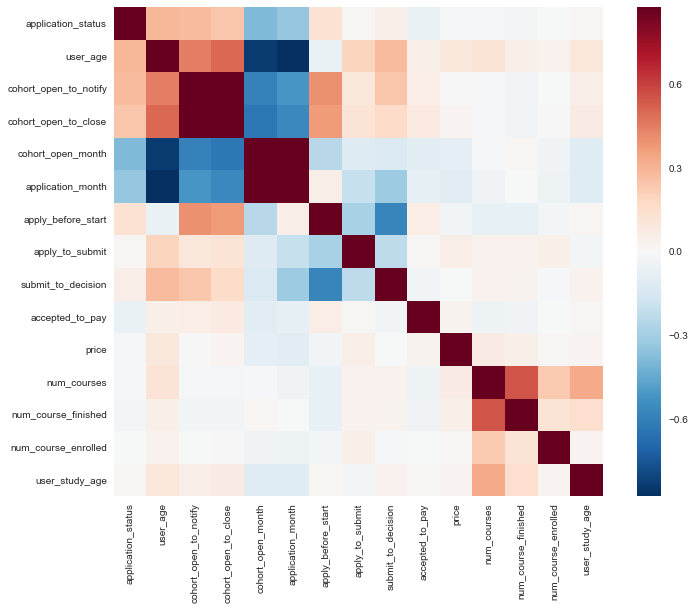

In [15]:
corrmat = dat.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

# seems like most correlated features: user_age, cohort_open_to_notify, cohort_open_to_close, cohort_open_month, application_month, apply_before_start

In [16]:
#nd_key = pd.get_dummies(dat['nd_key'])
application_type = pd.get_dummies(dat['application_type'])
applicant_geo = pd.get_dummies(dat['applicant_geo'])
df_1 = dat.iloc[:,3:19]
df_2 = pd.concat([df_1,application_type,applicant_geo],axis=1)

In [17]:
df_2.columns

Index(['application_status', 'user_age', 'cohort_open_to_notify',
       'cohort_open_to_close', 'cohort_open_month', 'application_month',
       'apply_before_start', 'apply_to_submit', 'submit_to_decision',
       'accepted_to_pay', 'price', 'num_courses', 'num_course_finished',
       'num_course_enrolled', 'user_study_age', 'connect', 'scholarship',
       'term', 'APAC', 'EMEA', 'Latam', 'North America (ex US)', 'US',
       'Unknown'],
      dtype='object')

In [18]:
sns.pairplot(df_2,hue="application_status")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# cohort-related features (cohort_open_to_close, cohort_open_to_notify) seems having an obvious pattern in clusters, could be due to diff. cohorts.
# hence try one cohort : 45 (nd209)

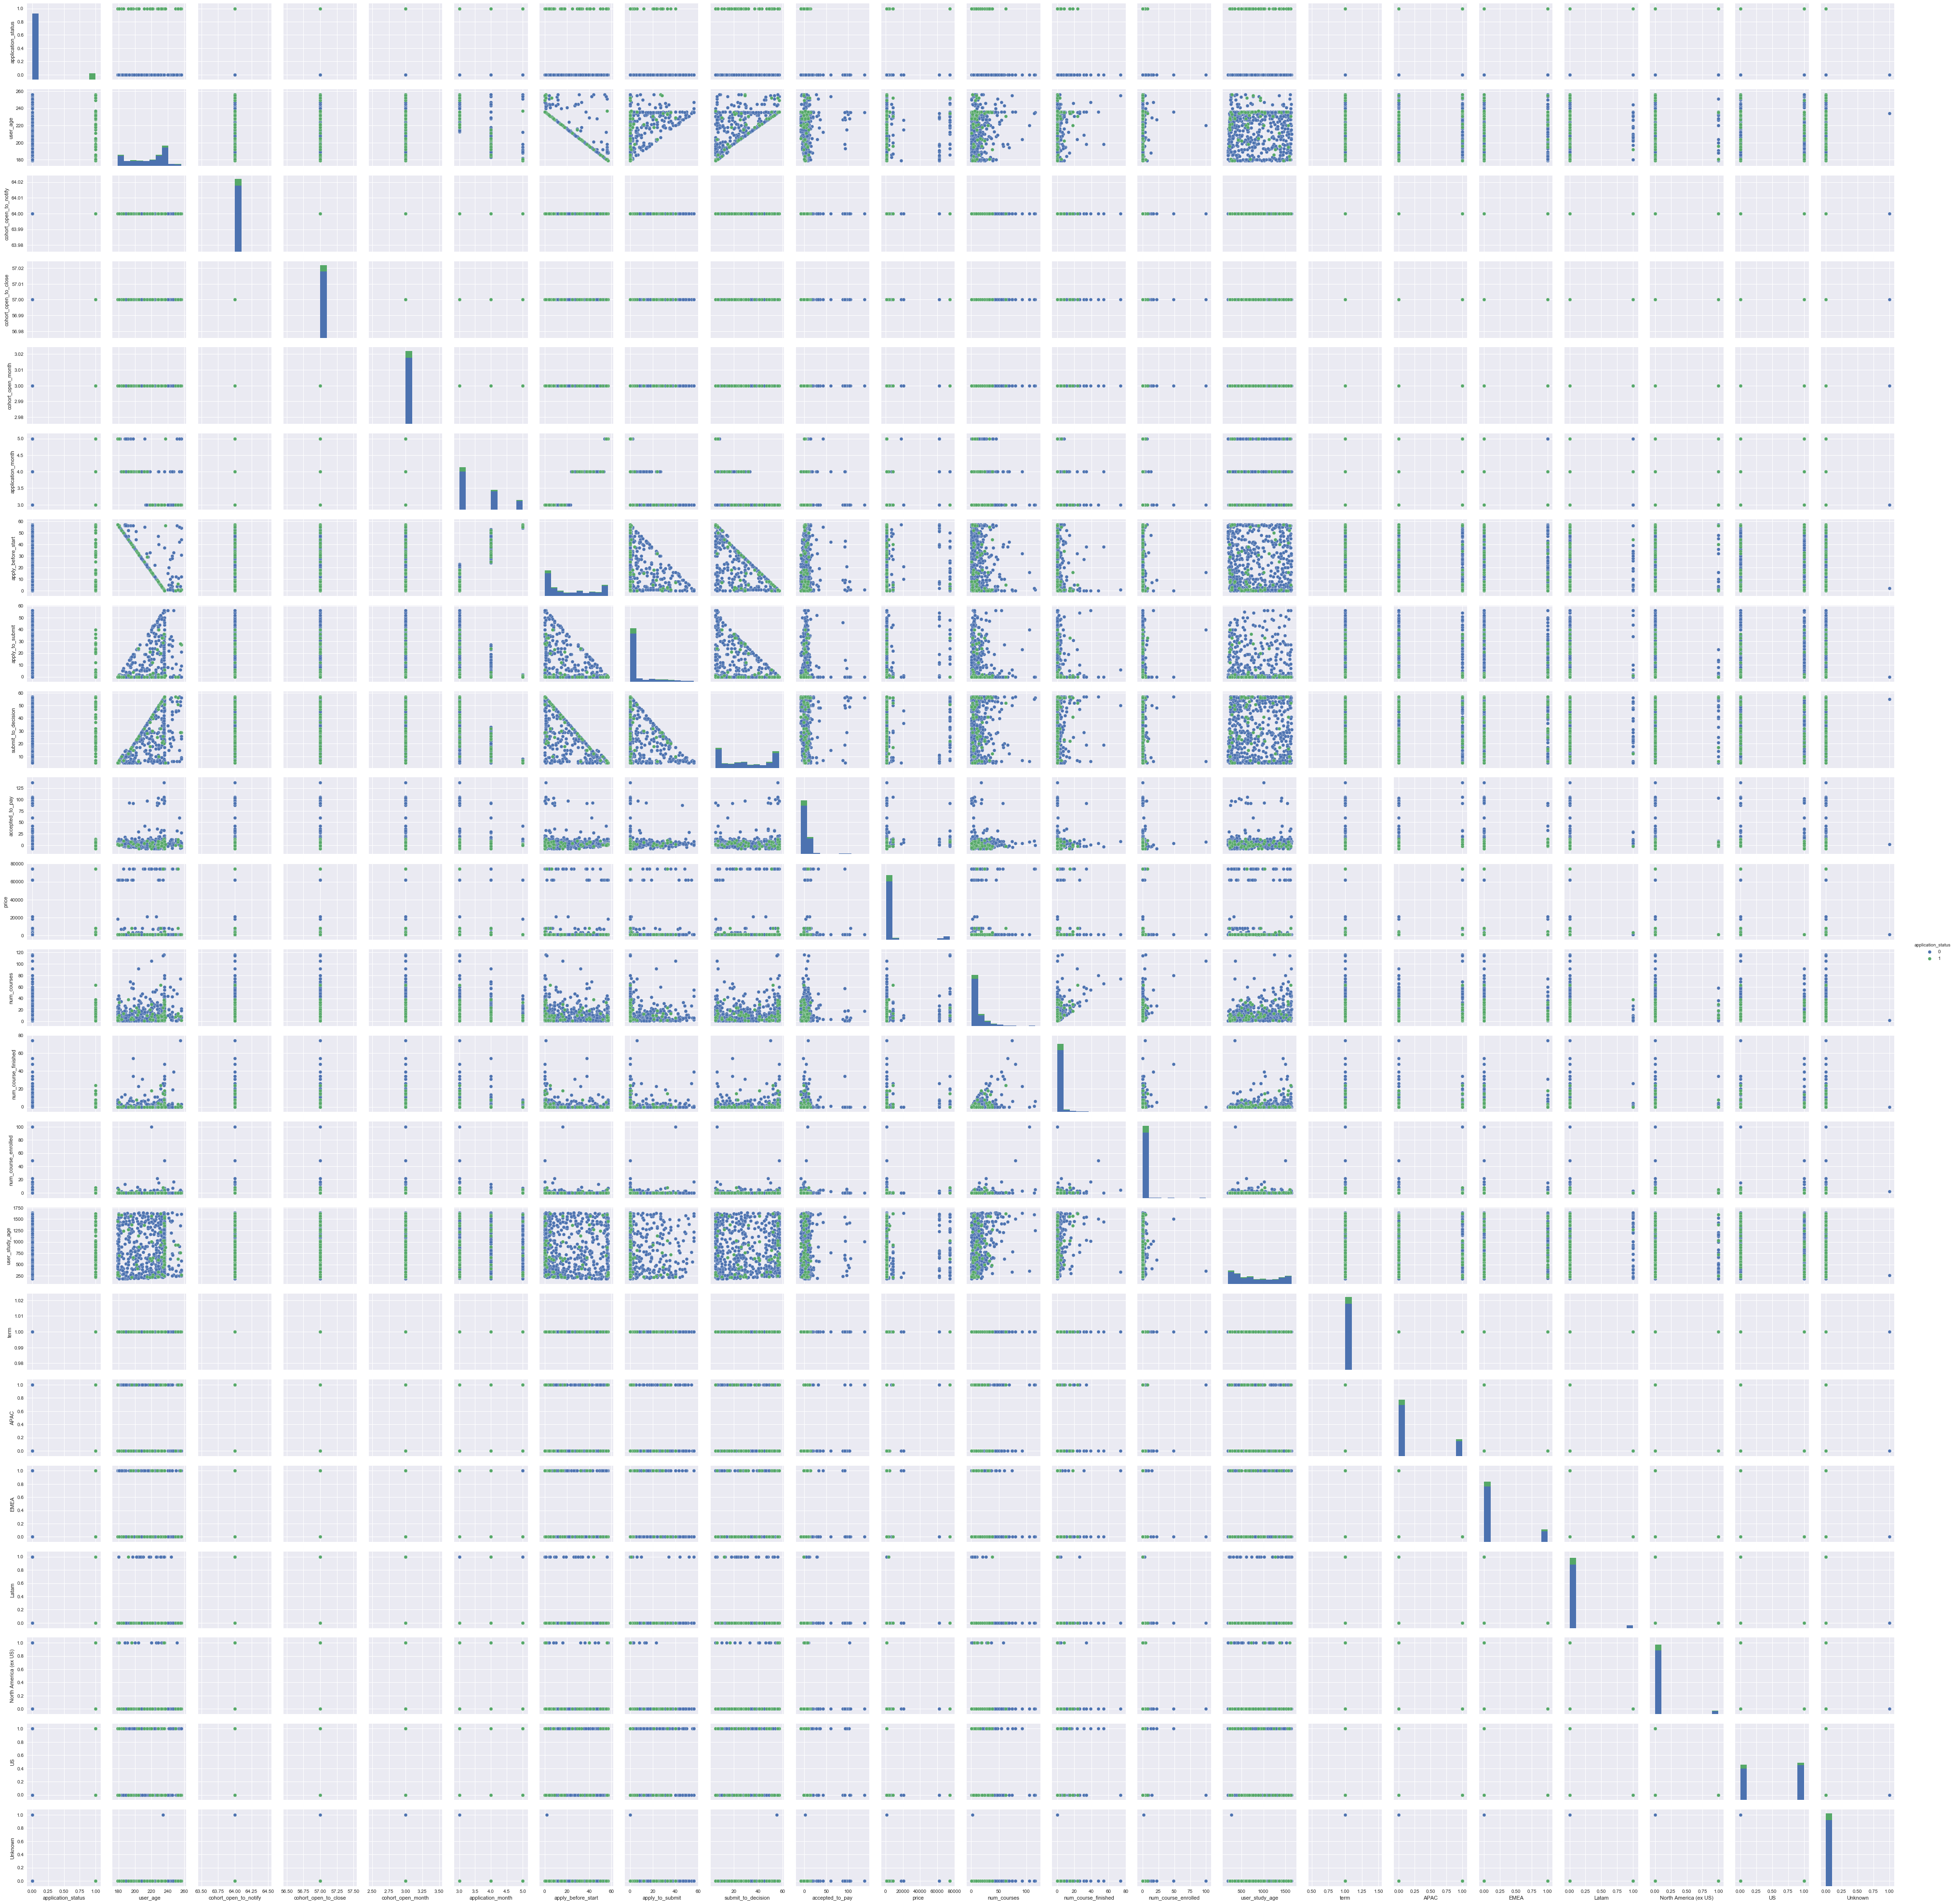

In [19]:
# cohort 45 only
data_45 = data[data['cohort_id']=='45']
data_45 = data_45.iloc[:,4:23]
data_45['price'].astype(str).astype(float)
application_type_45 = pd.get_dummies(data_45['application_type'])
applicant_geo_45 = pd.get_dummies(data_45['applicant_geo'])
df_45 = pd.concat([data_45.iloc[:,3:19],application_type_45,applicant_geo_45],axis=1)
sns.pairplot(df_45,hue="application_status")

In [20]:
cols = df_2.columns[1:]
logit = sm.Logit(df_2['application_status'], df_2[cols])
result = logit.fit()
print(result.summary())

         Current function value: 0.300722
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     application_status   No. Observations:                 4157
Model:                          Logit   Df Residuals:                     4135
Method:                           MLE   Df Model:                           21
Date:                Mon, 30 Oct 2017   Pseudo R-squ.:                  0.2832
Time:                        10:57:50   Log-Likelihood:                -1250.1
converged:                      False   LL-Null:                       -1744.1
                                        LLR p-value:                1.058e-195
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
user_age                 -0.0082      0.003     -2.351      0.019      -0.015      -0.001
cohort_open_to_notify    -0.2176

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Logistics Regression Result: price, courses taken history, study length with udacity, geo are not sig.

In [21]:
data.groupby('application_type')['application_id'].count()

application_type
connect          15
scholarship       1
term           4141
Name: application_id, dtype: int64

In [22]:
data.groupby('applicant_geo')['application_id'].count()

applicant_geo
APAC                      894
EMEA                      868
Latam                     114
North America (ex US)     165
US                       2114
Unknown                     2
Name: application_id, dtype: int64

In [23]:
data.groupby('nd_key')['application_id'].count()

nd_key
nd001-connect            2
nd002-connect            5
nd004-connect-reno       1
nd009-connect            7
nd013                 2284
nd113                    1
nd209                 1040
nd889                  817
Name: application_id, dtype: int64

In [24]:
# questions
sql_questions = "select distinct application_id,cohort_id,applicant_id,nd_key\
                        ,question_id,question_prompt,response,question_prompt||' A:'||response as q_r\
                from admissions.question_responses\
                where application_type != 'scholarship' and response is not null\
                  and question_id in ('question_id','48e7b492-62b4-4d99-b596-80d68f2966ae','cad2565e-8176-44b5-9080-14cfc67ea9b4','fba3666b-db04-46e9-8f3d-2a303f13e0a5','26330483-09a3-444a-b534-e9cd7021ec1c','42b96348-56c4-4e3b-b0f9-8d3911969e48','516737fe-4567-48d2-8645-08d335e21b0c','0c22dbaa-bf1d-4c67-be34-a61014591d6f','2ad03aaa-1b35-4381-9c43-907b1b4eba67','6afe0061-746b-4bd7-807c-393fe5c7599d','779c3b6c-3648-423b-8d3f-8a4f36f23e2a','1346c396-a687-4082-a10e-d3556ac50b4b','1cfe0061-746b-4bd7-807c-393fe5c7599d','ed06fc88-6a59-40a8-b7ea-ece90d83c333','fa332682-b62e-4791-b95f-c528b532a754','e42e1049-e459-4602-ae4b-cb78098dcf89','01f28833-152f-438d-a831-51e33583bde5','7c55f3cc-1c0b-4d95-97f9-cc3409e3145f','a633a338-9726-472a-a0ff-0d8695b30638','f1a93ec7-e2cd-46b6-ba28-2f36b30539a9','6967091c-09c6-4455-9f1e-d0de318bacc5','011ef02c-abea-476d-afdc-d1aa8a456b94','0f617540-5680-480c-aaf3-0663c17c3c7d','1dfe0061-746b-4bd7-807c-393fe5c7599d','20f21bd0-eb3e-4898-ae1f-eb994f9ce823','45781b84-093b-41c7-b5a4-c521f343bf21','47d35057-b1fb-4106-8218-7e551497420e','491b500b-26a2-425b-b142-00773f1d1938','5cf34496-6bc3-4c8d-9c6a-7c037f48669f','70ffc637-2162-484a-b863-3a1a1469f106','7a09e78a-8000-459e-9d79-aa21db135138','823a8248-b7d7-4dbe-a619-2969ca453f1e','8afe0061-746b-4bd7-807c-393fe5c7599d','8ea6732d-0ef9-489d-bf11-20673183a0c2','9481dc6b-c4e9-4207-a30c-65c3ac302bf5','995331ea-092b-4b71-8122-a0c65214c765','9d5c6390-a690-4d6d-8aaa-c60a772b4550','a26ac91f-c263-49f1-8171-9821bc4d2da5','a71ff6e3-1b33-4e11-94f1-5b94d786b5ab','a7b7f95b-1924-4189-840e-b5c407545908','ae155453-72b2-4247-8da5-dced5270f29b','bdc024d8-7712-48ff-b86e-292be1df0d9f','d3b0e6c7-0601-4651-851f-7ef4bea1aa6d','d8f9089c-c3a5-4d77-9c37-ae248e134e42','d9af077d-b729-4971-84b8-f86f390789c1','da04a859-199c-42cf-ab5d-6132bc529161','dc898f2e-1810-4d93-9db0-f381778d45e1','f254514a-26f4-4d29-83af-711c27d4862d','f34c024a-b446-464e-add0-558c9eb8a3c8','fa537969-017a-4816-a317-b5883305c723')"
df_questions = pd.read_sql(sql_questions,conn_laurel)
df_questions.head()

,application_id,cohort_id,applicant_id,nd_key,question_id,question_prompt,response,q_r
0,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,2ad03aaa-1b35-4381-9c43-907b1b4eba67,What do you hope to accomplish through this pr...,I am currently writing Machine Learning Code a...,What do you hope to accomplish through this pr...
1,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,48e7b492-62b4-4d99-b596-80d68f2966ae,What is the highest level of education you hav...,Master's degree,What is the highest level of education you hav...
2,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,516737fe-4567-48d2-8645-08d335e21b0c,What gender do you most identify with?,Male,What gender do you most identify with? A:Male
3,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,6967091c-09c6-4455-9f1e-d0de318bacc5,How many years of professional experience do y...,5+ years,How many years of professional experience do y...
4,0001883b-f88d-4662-afea-717fbba580a0,129,4746120864,nd889,779c3b6c-3648-423b-8d3f-8a4f36f23e2a,What is your primary purpose in taking this pr...,Grow skills for my current role,What is your primary purpose in taking this pr...


In [25]:
df_questions.shape

(480368, 8)

In [26]:
# merge data first
cols = ['application_id','cohort_id','applicant_id','nd_key','application_status']
df_qr = pd.merge(data[cols],df_questions,on=['application_id','cohort_id','applicant_id','nd_key'],how='inner')
df_qr.shape

(43378, 9)

In [27]:
# random sample and force paid and term_completed be 1:1
df_qr_0 = df_qr[df_qr['application_status']==0].reset_index()
df_qr_1 = df_qr[df_qr['application_status']==1].reset_index()
num = df_qr_1.shape[0]
df_qr_2 = df_qr_0.iloc[random.sample(range(df_qr_0.shape[0]),num),:]
df_qr_s = pd.concat([df_qr_1,df_qr_2],axis=0)
df_qr_s.groupby(['application_status'])['application_id'].count()

application_status
0    6295
1    6295
Name: application_id, dtype: int64

# education: Master and PhD have higher graduation rate

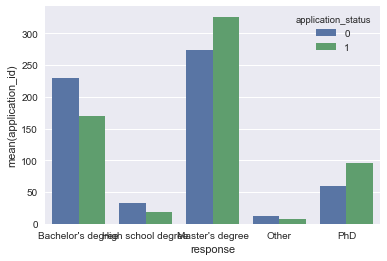

In [28]:
df_qr_edu = df_qr_s[df_qr_s['question_id']=='48e7b492-62b4-4d99-b596-80d68f2966ae']
d = pd.DataFrame(df_qr_edu.groupby(['response','application_status'])['application_id'].count()).reset_index()
sns.barplot(data=d,x='response',y='application_id',hue='application_status')

# employment: full time, student and self employed have higher graduation rate; part time has almost equal graduation rate

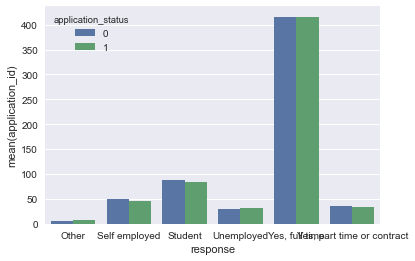

In [29]:
df_qr_emp = df_qr_s[df_qr_s['question_id']=='fba3666b-db04-46e9-8f3d-2a303f13e0a5']
d = pd.DataFrame(df_qr_emp.groupby(['response','application_status'])['application_id'].count()).reset_index()
sns.barplot(data=d,x='response',y='application_id',hue='application_status')

# Professional Experience: 5+ and 1-2+ years in industry have higher graduation rate

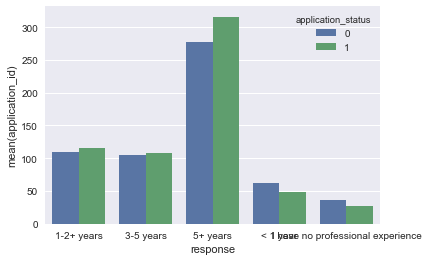

In [30]:
df_qr_pe = df_qr_s[df_qr_s['question_id']=='6967091c-09c6-4455-9f1e-d0de318bacc5']
d = pd.DataFrame(df_qr_pe.groupby(['response','application_status'])['application_id'].count()).reset_index()
sns.barplot(data=d,x='response',y='application_id',hue='application_status')

# Python : sig. for students who already know python

In [31]:
df_qr_s['python'] = 0
df_qr_s['python'] = np.where(df_qr_s['response'].str.contains('Python'),1,df_qr_s['python'])
df_qr_s['python'] = np.where(df_qr_s['question_prompt'].str.contains('Python')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['python'])

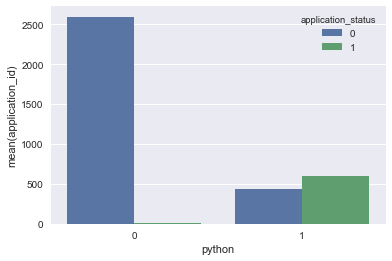

In [32]:
df_qr_python = df_qr_s.groupby(['application_id','application_status']).agg({'python':'max'}).reset_index()
df_qr_python = df_qr_python.groupby(['python','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_python,x='python',y='application_id',hue='application_status')

# Java : not sig.

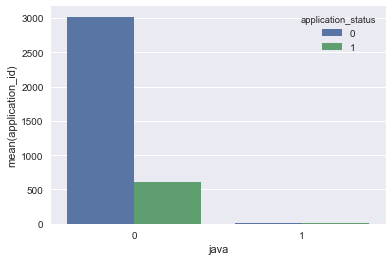

In [33]:
df_qr_s['java'] = 0
df_qr_s['java'] = np.where(df_qr_s['response'].str.contains('Java'),1,df_qr_s['java'])
df_qr_s['java'] = np.where(df_qr_s['question_prompt'].str.contains('Java')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['java'])
df_qr_java = df_qr_s.groupby(['application_id','application_status']).agg({'java':'max'}).reset_index()
df_qr_java = df_qr_java.groupby(['java','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_java,x='java',y='application_id',hue='application_status')

# C++ : sig. for students who already know c++

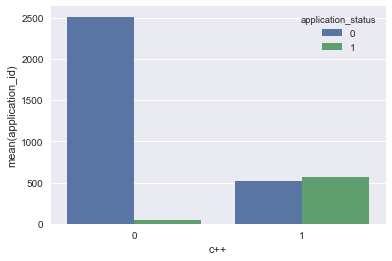

In [34]:
df_qr_s['c++'] = 0
df_qr_s['c++'] = np.where(df_qr_s['response'].str.contains('C\+\+'),1,df_qr_s['c++'])
df_qr_s['c++'] = np.where(df_qr_s['question_prompt'].str.contains('C\+\+')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['c++'])
df_qr_cplus = df_qr_s.groupby(['application_id','application_status']).agg({'c++':'max'}).reset_index()
df_qr_cplus = df_qr_cplus.groupby(['c++','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_cplus,x='c++',y='application_id',hue='application_status')

# Probability: sig.

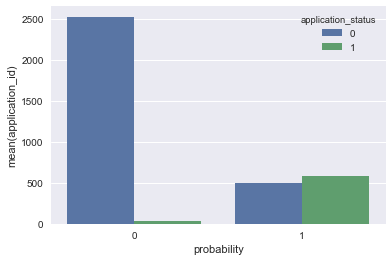

In [35]:
df_qr_s['probability'] = 0
df_qr_s['probability'] = np.where(df_qr_s['response'].str.lower().str.contains('probability'),1,df_qr_s['probability'])
df_qr_s['probability'] = np.where(df_qr_s['question_prompt'].str.lower().str.contains('probability')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['probability'])
df_qr_probability = df_qr_s.groupby(['application_id','application_status']).agg({'probability':'max'}).reset_index()
df_qr_probability = df_qr_probability.groupby(['probability','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_probability,x='probability',y='application_id',hue='application_status')

# Statistics : sig.

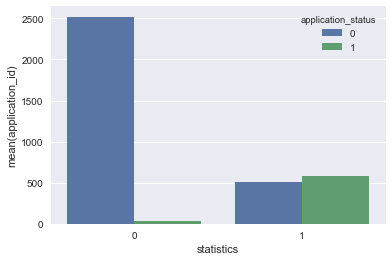

In [36]:
df_qr_s['statistics'] = 0
df_qr_s['statistics'] = np.where(df_qr_s['response'].str.lower().str.contains('statistics'),1,df_qr_s['statistics'])
df_qr_s['statistics'] = np.where(df_qr_s['question_prompt'].str.lower().str.contains('statistics')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['statistics'])
df_qr_statistics = df_qr_s.groupby(['application_id','application_status']).agg({'statistics':'max'}).reset_index()
df_qr_statistics = df_qr_statistics.groupby(['statistics','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_statistics,x='statistics',y='application_id',hue='application_status')

# Linear algebra: sig.

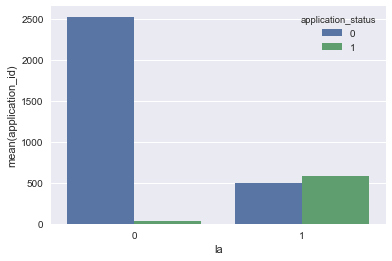

In [37]:
df_qr_s['la'] = 0
df_qr_s['la'] = np.where(df_qr_s['response'].str.lower().str.contains('linear algebra'),1,df_qr_s['la'])
df_qr_s['la'] = np.where(df_qr_s['question_prompt'].str.lower().str.contains('linear algebra')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['la'])
df_qr_la = df_qr_s.groupby(['application_id','application_status']).agg({'la':'max'}).reset_index()
df_qr_la = df_qr_la.groupby(['la','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_la,x='la',y='application_id',hue='application_status')

# Computer Science: not sig.

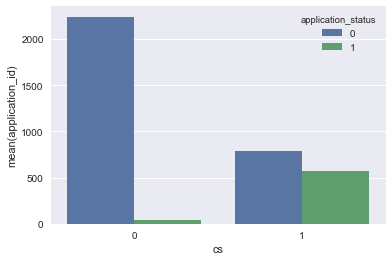

In [38]:
df_qr_s['cs'] = 0
df_qr_s['cs'] = np.where(df_qr_s['response'].str.lower().str.contains('computer science'),1,df_qr_s['cs'])
df_qr_s['cs'] = np.where(df_qr_s['question_prompt'].str.lower().str.contains('computer science')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['cs'])
df_qr_cs = df_qr_s.groupby(['application_id','application_status']).agg({'cs':'max'}).reset_index()
df_qr_cs = df_qr_cs.groupby(['cs','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_cs,x='cs',y='application_id',hue='application_status')

# Machine Learning: kind of sig.

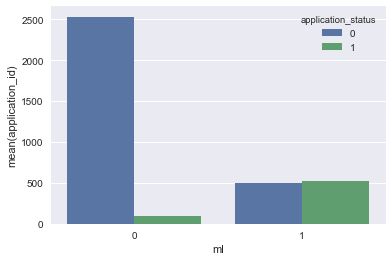

In [39]:
df_qr_s['ml'] = 0
df_qr_s['ml'] = np.where(df_qr_s['response'].str.lower().str.contains('machine learning'),1,df_qr_s['ml'])
df_qr_s['ml'] = np.where(df_qr_s['question_prompt'].str.lower().str.contains('machine learning')
                             &df_qr_s['response'].str.match('.*[1-9].*'),1,df_qr_s['ml'])
df_qr_ml = df_qr_s.groupby(['application_id','application_status']).agg({'ml':'max'}).reset_index()
df_qr_ml = df_qr_ml.groupby(['ml','application_status'])['application_id'].count().reset_index()
sns.barplot(data=df_qr_ml,x='ml',y='application_id',hue='application_status')

# merge data to do another logistics regression with question responses

In [40]:
df_q = df_qr

In [41]:
#education
df_q = df_q.assign(education = '0')
df_q['education'] = np.where(df_q['question_id']=='48e7b492-62b4-4d99-b596-80d68f2966ae',df_q['response'],'0')
education = df_q.groupby('application_id').agg({'education':'max'}).reset_index()

In [42]:
#employment
df_q = df_q.assign(employment = '0')
df_q['employment'] = np.where(df_q['question_id']=='fba3666b-db04-46e9-8f3d-2a303f13e0a5',df_q['response'],'0')
employment = df_q.groupby('application_id').agg({'employment':'max'}).reset_index()

In [43]:
#professional experience
df_q = df_q.assign(professional_experience = '0')
df_q['professional_experience'] = np.where(df_q['question_id']=='6967091c-09c6-4455-9f1e-d0de318bacc5',df_q['response'],'0')
professional_experience = df_q.groupby('application_id').agg({'professional_experience':'max'}).reset_index()

In [44]:
#python
df_q = df_q.assign(python = 0)
df_q['python'] = np.where(df_q['response'].str.lower().str.contains('python'),1,df_q['python'])
df_q['python'] = np.where(df_q['question_prompt'].str.lower().str.contains('python')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['python'])
python = df_q.groupby('application_id').agg({'python':'max'}).reset_index()

In [45]:
#java
df_q = df_q.assign(java = 0)
df_q['java'] = np.where(df_q['response'].str.lower().str.contains('java'),1,df_q['java'])
df_q['java'] = np.where(df_q['question_prompt'].str.lower().str.contains('java')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['java'])
java = df_q.groupby('application_id').agg({'java':'max'}).reset_index()

In [46]:
#C++
df_q = df_q.assign(cplus = 0)
df_q['cplus'] = np.where(df_q['response'].str.lower().str.contains('c\+\+'),1,df_q['cplus'])
df_q['cplus'] = np.where(df_q['question_prompt'].str.lower().str.contains('c\+\+')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['cplus'])
cplus = df_q.groupby('application_id').agg({'cplus':'max'}).reset_index()

In [47]:
#probability
df_q = df_q.assign(probability = 0)
df_q['probability'] = np.where(df_q['response'].str.lower().str.contains('probability'),1,df_q['probability'])
df_q['probability'] = np.where(df_q['question_prompt'].str.lower().str.contains('probability')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['probability'])
probability = df_q.groupby('application_id').agg({'probability':'max'}).reset_index()

In [48]:
#statistics
df_q = df_q.assign(statistics = 0)
df_q['statistics'] = np.where(df_q['response'].str.lower().str.contains('statistics'),1,df_q['statistics'])
df_q['statistics'] = np.where(df_q['question_prompt'].str.lower().str.contains('statistics')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['statistics'])
statistics = df_q.groupby('application_id').agg({'statistics':'max'}).reset_index()

In [49]:
#linear algebra
df_q = df_q.assign(linear_algebra = 0)
df_q['linear_algebra'] = np.where(df_q['response'].str.lower().str.contains('linear algebra'),1,df_q['linear_algebra'])
df_q['linear_algebra'] = np.where(df_q['question_prompt'].str.lower().str.contains('linear algebra')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['linear_algebra'])
linear_algebra = df_q.groupby('application_id').agg({'linear_algebra':'max'}).reset_index()

In [50]:
#computer science
df_q = df_q.assign(computer_science = 0)
df_q['computer_science'] = np.where(df_q['response'].str.lower().str.contains('computer science'),1,df_q['computer_science'])
df_q['computer_science'] = np.where(df_q['question_prompt'].str.lower().str.contains('computer science')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['computer_science'])
computer_science = df_q.groupby('application_id').agg({'computer_science':'max'}).reset_index()

In [51]:
#machine learning
df_q = df_q.assign(machine_learning = 0)
df_q['machine_learning'] = np.where(df_q['response'].str.lower().str.contains('machine learning'),1,df_q['machine_learning'])
df_q['machine_learning'] = np.where(df_q['question_prompt'].str.lower().str.contains('machine learning')
                             &df_q['response'].str.match('.*[1-9].*'),1,df_q['machine_learning'])
machine_learning = df_q.groupby('application_id').agg({'machine_learning':'max'}).reset_index()

In [52]:
d_education = pd.get_dummies(education['education'])
d_edu = pd.concat([education['application_id'],d_education],axis=1)
d_employment = pd.get_dummies(employment['employment'])
d_emp = pd.concat([employment['application_id'],d_employment],axis=1)
d_professional_experience = pd.get_dummies(professional_experience['professional_experience'])
d_prof_exp = pd.concat([professional_experience['application_id'],d_professional_experience],axis=1)

In [53]:
import functools
dfs = [df_q,d_edu,d_emp,d_prof_exp]#,python,java,cplus,probability,statistics,linear_algebra,computer_science,machine_learning]
df_qq = functools.reduce(lambda left,right: pd.merge(left,right,on='application_id'), dfs)

In [54]:
cols = df_qq.columns[12:36]
logit = sm.Logit(df_qq['application_status'],df_qq[cols].astype(float))
result = logit.fit()
print(result.summary())

         Current function value: 0.405470
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     application_status   No. Observations:                43378
Model:                          Logit   Df Residuals:                    43356
Method:                           MLE   Df Model:                           21
Date:                Mon, 30 Oct 2017   Pseudo R-squ.:                 0.02096
Time:                        10:59:49   Log-Likelihood:                -17588.
converged:                      False   LL-Null:                       -17965.
                                        LLR p-value:                8.360e-146
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
python                                0.3390      0.047      7.211      0.000       0.247       0.

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
